<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Библиотеки и методы

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [3]:
random_state = 42

## Подготовка

In [4]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [5]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
data = data.resample('1H').sum()

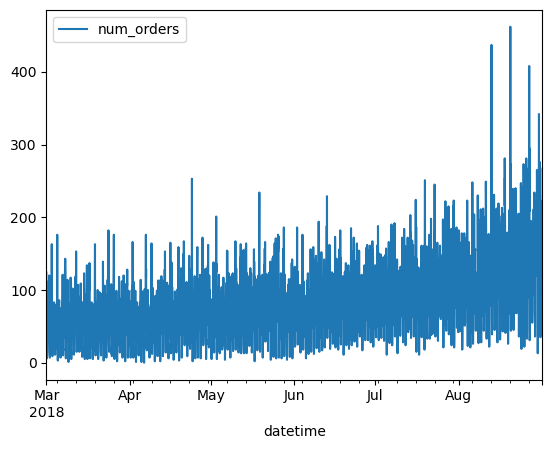

In [7]:
data.plot();

## Анализ

In [8]:
analising_data = data.copy()
analising_data['week_rolling_mean'] = data.rolling(168).mean()
analising_data['week_std'] = analising_data['num_orders'].rolling(168).std()

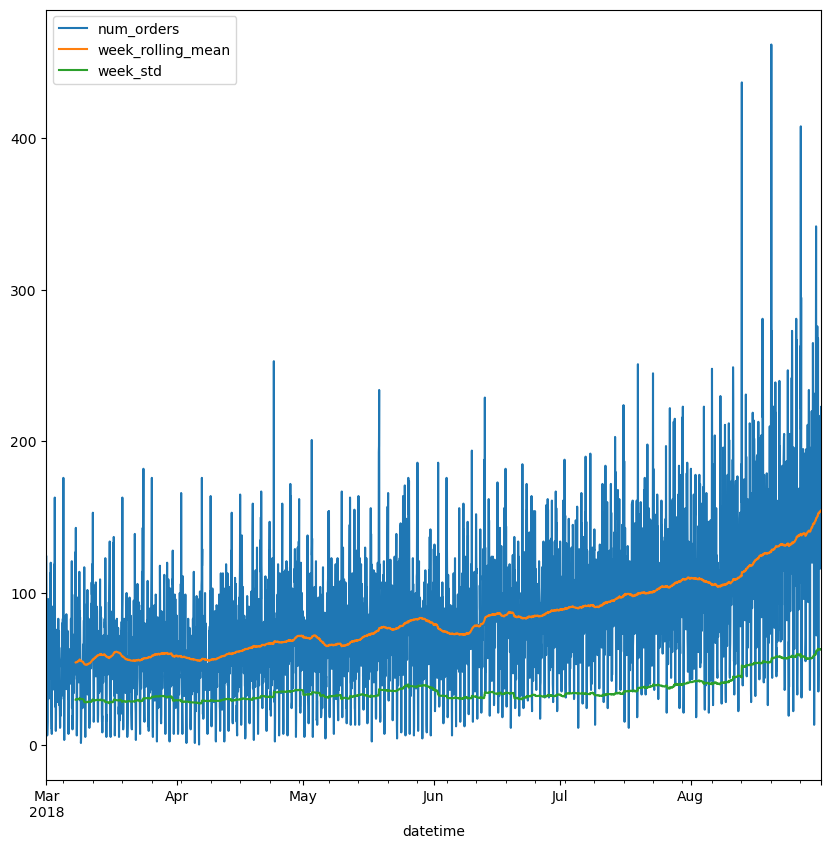

In [9]:
plt.figure(figsize=(10, 10))
analising_data.plot(ax=plt.gca());

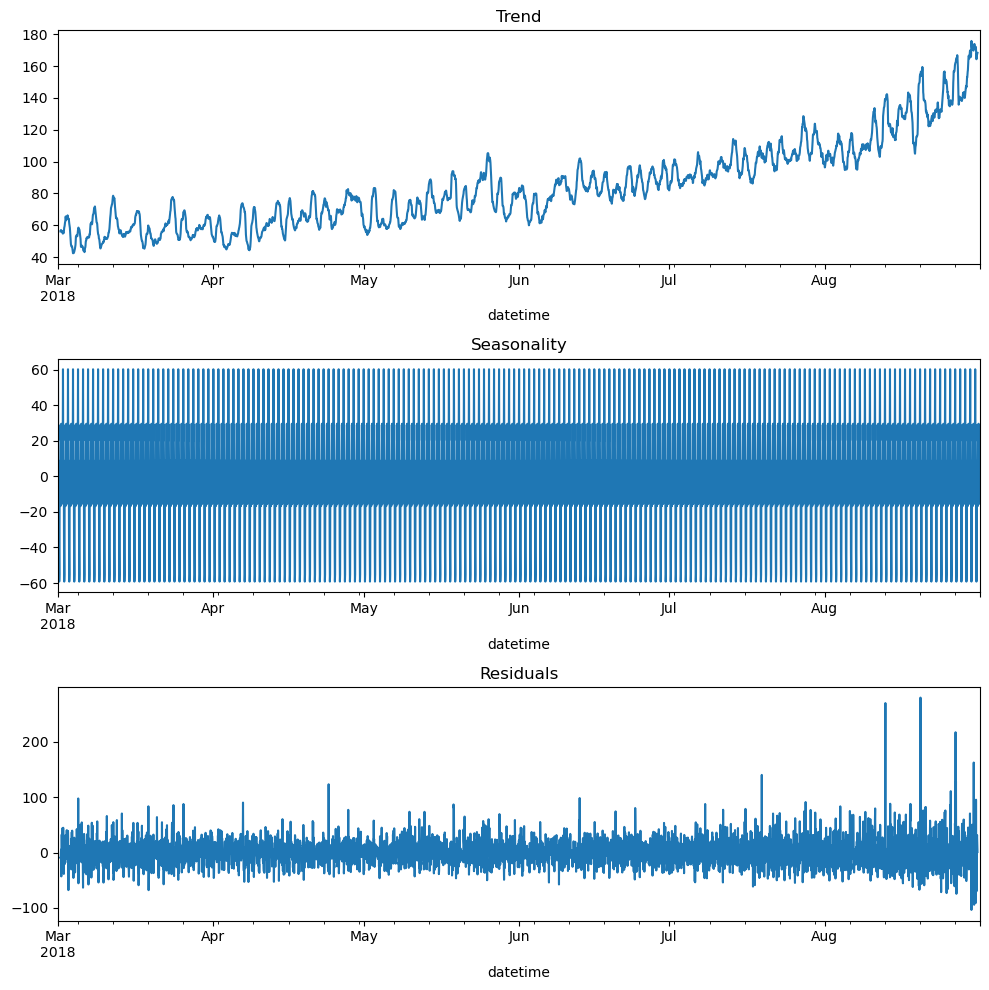

In [10]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

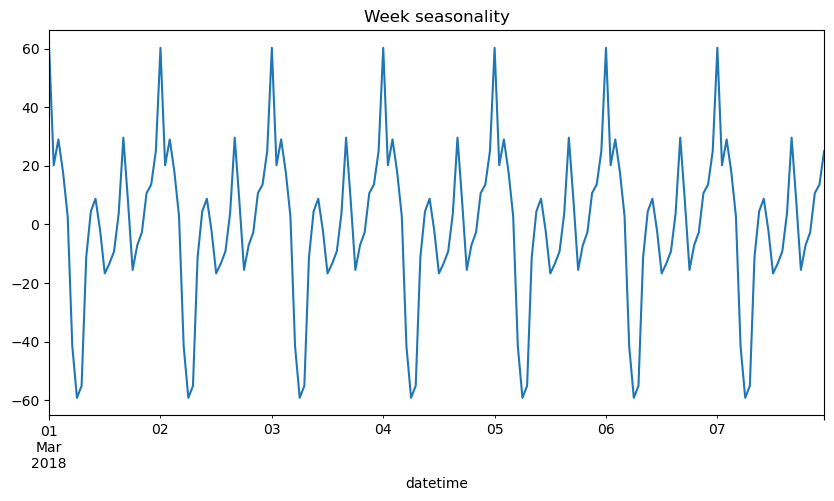

In [11]:
plt.figure(figsize=(10, 5))
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Week seasonality');

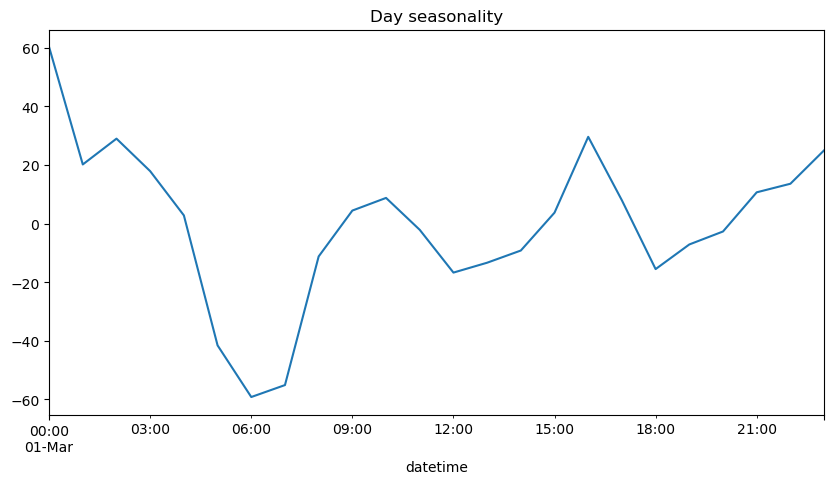

In [12]:
plt.figure(figsize=(10, 5))
decomposed.seasonal['2018-03-01'].plot(ax=plt.gca())
plt.title('Day seasonality');

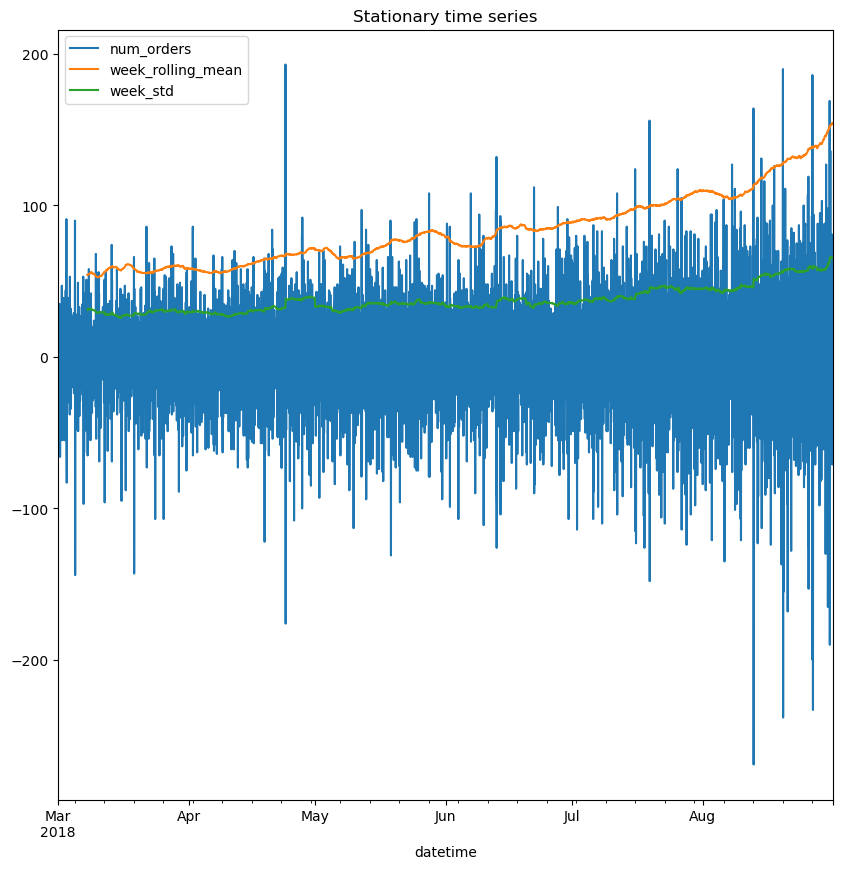

In [13]:
shifted_data = data.copy()
shifted_data -= shifted_data.shift()
shifted_data['week_rolling_mean'] = data.rolling(168).mean()
shifted_data['week_std'] = shifted_data['num_orders'].rolling(168).std()
plt.figure(figsize=(10, 10))
shifted_data.plot(ax=plt.gca())
plt.title('Stationary time series');

### Вывод
* Наблюдается увеличение дисперсии. 
* Общий тренд свидетельствует о постоянном увеличении числа заказов и пользователей. 
* Отмечается значительное снижение количества заказов в ранние утренние часы. 
* Временной ряд не обладает стационарностью, поскольку подвержен изменяющемуся во времени тренду.

## Обучение

In [14]:
make_features(data, 6, 6)

In [15]:
data.duplicated().sum()

0

In [16]:
train = data.drop('num_orders', axis=1)
target = data['num_orders'].astype('int')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.1, random_state=random_state)

In [18]:
model = CatBoostRegressor(random_state=random_state)

grid = {'learning_rate': [0.01, 0.03, 0.1, 0.3],
        'depth': [4, 6, 8, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 11, 13],
        'iterations': [100, 200, 300, 400, 500],
        'border_count': [32, 64, 128, 256],
        'bagging_temperature': [0, 1, 2],
        'min_child_samples': [1, 5, 10, 20]}

randomized_search_result = model.randomized_search(grid,
                                                   X=X_train,
                                                   y=y_train,
                                                   cv=3,
                                                   n_iter=20,
                                                   partition_random_seed=random_state,
                                                   plot=True,
                                                   refit=True,
                                                   )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 93.4286278	test: 92.6073754	best: 92.6073754 (0)	total: 56ms	remaining: 27.9s
1:	learn: 91.1381111	test: 90.2792896	best: 90.2792896 (1)	total: 57ms	remaining: 14.2s
2:	learn: 88.9266687	test: 88.0448561	best: 88.0448561 (2)	total: 57.7ms	remaining: 9.56s
3:	learn: 86.7379709	test: 85.8067391	best: 85.8067391 (3)	total: 58.4ms	remaining: 7.24s
4:	learn: 84.6686812	test: 83.7121293	best: 83.7121293 (4)	total: 59.1ms	remaining: 5.85s
5:	learn: 82.6604320	test: 81.6501803	best: 81.6501803 (5)	total: 61.3ms	remaining: 5.04s
6:	learn: 80.7040224	test: 79.6425894	best: 79.6425894 (6)	total: 62ms	remaining: 4.36s
7:	learn: 78.8867153	test: 77.8227160	best: 77.8227160 (7)	total: 62.8ms	remaining: 3.86s
8:	learn: 77.0616621	test: 75.9543628	best: 75.9543628 (8)	total: 63.5ms	remaining: 3.46s
9:	learn: 75.3801155	test: 74.2270977	best: 74.2270977 (9)	total: 64.2ms	remaining: 3.14s
10:	learn: 73.6840021	test: 72.5091764	best: 72.5091764 (10)	total: 64.7ms	remaining: 2.87s
11:	learn: 72.

In [19]:
X_train.fillna(0, inplace=True)

In [20]:
model = LogisticRegression(tol=0.01, random_state=random_state)

param_dist = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_grid = RandomizedSearchCV(model,
                          param_dist,
                          n_iter=50,
                          cv=3,
                          verbose=5,
                          random_state=random_state,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1)

lr_grid.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 28 is smaller than n_iter=50. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 2/3] END C=0.001, penalty=l1, solver=saga;, score=-2202.554 total time=   0.3s
[CV 1/3] END C=0.001, penalty=l1, solver=liblinear;, score=-2033.091 total time=   0.4s
[CV 1/3] END C=0.001, penalty=l1, solver=saga;, score=-2033.091 total time=   0.4s
[CV 2/3] END C=0.001, penalty=l1, solver=liblinear;, score=-2202.554 total time=   0.4s
[CV 3/3] END C=0.001, penalty=l1, solver=liblinear;, score=-2460.993 total time=   0.4s
[CV 2/3] END C=0.001, penalty=l2, solver=liblinear;, score=-1885.995 total time=   0.6s
[CV 3/3] END C=0.001, penalty=l1, solver=saga;, score=-2460.415 total time=   0.7s
[CV 1/3] END C=0.001, penalty=l2, solver=liblinear;, score=-1595.485 total time=   0.7s
[CV 3/3] END C=0.001, penalty=l2, solver=liblinear;, score=-1732.861 total time=   0.7s
[CV 1/3] END C=0.01, penalty=l1, solver=liblinear;, score=-1563.843 total time=   0.7s
[CV 2/3] END C=0.01, penalty=l1, solver=liblinear;, score=-1778.890 total time=   0.7s
[CV 3/3] END C=0.01, penalty=l1, solver=liblinear

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(random_state=42, tol=0.01),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=5)

In [21]:
mse = lr_grid.best_score_
lr_rmse = math.sqrt(abs(mse))
print("Best RMSE Score:", lr_rmse)

Best RMSE Score: 40.362646817195305


### Вывод
Лучший результат показала модель градиентного бустинга с RMSE = 31.2, берем ее за основу.


## Тестирование

### MAE по медиане

In [22]:
pred_median = np.ones(y_test.shape) * target.median()
med_rsme = math.sqrt(mean_squared_error(y_test, pred_median))
print("RMSE:", med_rsme)

RMSE: 45.03608407464264


### МАЕ предыдущим значением ряда

In [23]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
shifted_rsme = math.sqrt(mean_squared_error(y_test, pred_previous))
print("RMSE:", shifted_rsme)

RMSE: 62.236994134630464


In [24]:
best_params = randomized_search_result['params']

best_model = CatBoostRegressor(**best_params, random_state=random_state)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

final_cb_rsme = math.sqrt(mean_squared_error(y_test, y_pred))

print(f'RMSE: {final_cb_rsme}')

0:	learn: 43.3550379	total: 1.11ms	remaining: 556ms
1:	learn: 41.8459155	total: 2.05ms	remaining: 510ms
2:	learn: 40.5606444	total: 3.13ms	remaining: 518ms
3:	learn: 39.4723540	total: 4.17ms	remaining: 518ms
4:	learn: 38.5766708	total: 5ms	remaining: 495ms
5:	learn: 37.7353848	total: 5.88ms	remaining: 484ms
6:	learn: 36.9994835	total: 6.98ms	remaining: 492ms
7:	learn: 36.3459510	total: 8.06ms	remaining: 495ms
8:	learn: 35.7857487	total: 9.3ms	remaining: 507ms
9:	learn: 35.3469086	total: 10.4ms	remaining: 507ms
10:	learn: 34.9706021	total: 11.2ms	remaining: 497ms
11:	learn: 34.5598465	total: 12ms	remaining: 487ms
12:	learn: 34.2097046	total: 13ms	remaining: 487ms
13:	learn: 33.9285672	total: 14ms	remaining: 485ms
14:	learn: 33.6557282	total: 14.8ms	remaining: 479ms
15:	learn: 33.4055830	total: 15.6ms	remaining: 471ms
16:	learn: 33.2163775	total: 16.4ms	remaining: 467ms
17:	learn: 33.0214699	total: 17.5ms	remaining: 469ms
18:	learn: 32.7937374	total: 18.6ms	remaining: 470ms
19:	learn: 32

In [30]:
index = ['median',
         'shifted',
         'final CBR']
data = {'RMSE':[med_rsme,
                shifted_rsme,
                final_cb_rsme]
}

In [31]:
scores_data = pd.DataFrame(data=data, index=index)
scores_data

,RMSE
median,45.036084
shifted,62.236994
final CBR,30.117088


### Вывод

Финальный результат RMSE CBR = 30.1, что удовлетворяет условию задачи.

Также, проведено сравнение с прогнозированием временных ряды без обучения двумя способами, модель показала лучший показатель, что говорит о ее эффективности.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48